In [ ]:
!pip install spacy-transformers
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.8/795.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.8
    Uninstalling spacy-3.8.8:
      Successfully uninstalled spacy-3.8.8


In [ ]:
import spacy
from spacy.tokens import DocBin
import pandas as pd
from sklearn.model_selection import train_test_split
import ast

# ===============================================================
# 1) LOAD DATA
# ===============================================================
df = pd.read_csv("/content/hateXplain_cleaned.csv")

def reconstruct_text(x):
    try:
        tokens = ast.literal_eval(x)
        return " ".join(tokens)
    except:
        return ""

df["text"] = df["post_tokens"].apply(reconstruct_text)

df = df[["text", "label"]].dropna()

valid_labels = ['offensive', 'hatespeech', 'normal']
df = df[df["label"].isin(valid_labels)]

print("Dataset loaded:", df.shape)
print(df.head())

# ===============================================================
# 2) TRAIN / DEV SPLIT
# ===============================================================
train_df, dev_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label"]
)

print(f"Train size: {len(train_df)}, Dev size: {len(dev_df)}")

# ===============================================================
# 3) FUNCTION TO CREATE SPACY DOCBIN
# ===============================================================
cats = ['offensive', 'hatespeech', 'normal']

def make_docs(dataframe, output_path):
    nlp = spacy.blank("en")
    docbin = DocBin()

    for _, row in dataframe.iterrows():
        text = row["text"]
        label = row["label"]

        if not isinstance(text, str) or text.strip() == "":
            continue  # skip empty

        doc = nlp.make_doc(text)
        doc.cats = {c: (1.0 if c == label else 0.0) for c in cats}
        docbin.add(doc)

    docbin.to_disk(output_path)
    print(f"Saved: {output_path}")

# ===============================================================
# 4) CREATE THE DATASETS
# ===============================================================
make_docs(train_df, "./train.spacy")
make_docs(dev_df, "./dev.spacy")


Dataset loaded: (48251, 2)
  text       label
0        offensive
1       hatespeech
2       hatespeech
3           normal
4           normal
Train size: 41013, Dev size: 7238
Saved: ./train.spacy
Saved: ./dev.spacy


In [ ]:
config = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.textcat]
labels = ["offensive", "hatespeech", "normal"]
exclusive_classes = true

"""

with open("/content/config.cfg", "w") as f:
    f.write(config.strip() + "\n")

print("Corrected config.cfg file created successfully by moving labels and exclusive_classes to initialize.textcat!")

Corrected config.cfg file created successfully by moving labels and exclusive_classes to initialize.textcat!


In [ ]:
!python -m spacy train /content/config.cfg \
    --output /content/output_roberta_textcat \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✘ Config validation error
initialize -> textcat	extra fields not permitted
{'vectors': None, 'init_tok2vec': None, 'vocab_data': None, 'lookups': None, 'before_init': None, 'after_init': None, 'components': {}, 'textcat': {'labels': ['offensive', 'hatespeech', 'normal'], 'exclusive_classes': True}, 'tokenizer': {}}


In [ ]:
import spacy

# Load your trained model
nlp = spacy.load("/content/output_roberta_textcat/model-best")

# Test on real tweets
test_tweets = [
    "I hate all immigrants, they should go back to their country",
    "Good morning everyone, have a wonderful day!",
    "women belong in the kitchen",
    "can't wait for the concert tonight!!",
    "all muslims are terrorists",
    "thanks for the help bro, really appreciate it",
    "kill yourself you worthless piece of shit",
    "love this weather, perfect day for a walk"
]

print("🤖 Hate/Offensive/Normal Detector (RoBERTa)\n" + "="*60)
for tweet in test_tweets:
    doc = nlp(tweet)
    pred_label = max(doc.cats, key=doc.cats.get)
    confidence = doc.cats[pred_label]
    print(f"{tweet}")
    print(f"  → {pred_label.upper():11} (confidence: {confidence:.3f})\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the best model to your Drive (takes ~1.1 GB for roberta-base)
!cp -r /content/output_roberta_textcat/model-best "/content/drive/MyDrive/roberta_hate_speech_model"

print("Model saved to your Google Drive → MyDrive/roberta_hate_speech_model")

# Task
Fix the `config.cfg` file by moving the `labels` and `exclusive_classes` parameters from `[initialize.textcat]` to `[initialize.components.textcat]`, then retrain the spaCy model using the corrected configuration to ensure training starts without errors.

## Fix Config File

### Subtask:
Modify the `config.cfg` file to correctly structure the `initialize.components.textcat` section, ensuring the `[initialize.components]` section is present and the `labels` and `exclusive_classes` are properly defined within `[initialize.components.textcat]`.


**Reasoning**:
The previous attempt to fix the `config.cfg` file was incorrect, leading to a validation error. The `labels` and `exclusive_classes` for the `textcat` component need to be nested under `[initialize.components.textcat]` instead of `[initialize.textcat]`. This step will correct the `config` string and overwrite the `config.cfg` file.



In [ ]:
config_new = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
exclusive_classes = true
"""

with open("/content/config.cfg", "w") as f:
    f.write(config_new.strip() + "\n")

print("Corrected config.cfg file created successfully with labels and exclusive_classes under initialize.components.textcat!")

Corrected config.cfg file created successfully with labels and exclusive_classes under initialize.components.textcat!


## Retrain Model

### Subtask:
Execute the `spacy train` command again with the corrected `config.cfg` file to initiate the model training.


**Reasoning**:
The config file has been corrected. Now, I will re-run the `spacy train` command using the updated `config.cfg` to initiate model training.



In [ ]:
!python -m spacy train /content/config.cfg \
    --output /content/output_roberta_textcat \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:09:23.849834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763496563.869515    7365 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763496563.875552    7365 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763496563.891250    7365 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763496563.891278    7365 computation_placer.cc:177] computation placer already registered. Pl

**Reasoning**:
The previous attempt to fix the config file resulted in an error `textcat -> exclusive_classes extra fields not permitted` within `[initialize.components]`. This indicates that `labels` and `exclusive_classes` should not be placed under `[initialize.components.textcat]`. Instead, these parameters, which define the behavior of the `textcat` component, should be moved directly under the `[components.textcat]` section.



In [ ]:
config_corrected = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"
labels = ["offensive", "hatespeech", "normal"]
exclusive_classes = true

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}
"""

with open("/content/config.cfg", "w") as f:
    f.write(config_corrected.strip() + "\n")

print("Corrected config.cfg file created successfully with labels and exclusive_classes directly under components.textcat!")

Corrected config.cfg file created successfully with labels and exclusive_classes directly under components.textcat!


**Reasoning**:
Now that the `config.cfg` file has been corrected, I will re-run the `spacy train` command to initiate the model training. This will test if the configuration is finally valid.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✘ Config validation error
textcat -> exclusive_classes	extra fields not permitted
textcat -> labels	extra fields not permitted
{'nlp': <spacy.lang.en.English object at 0x7d1c4901a870>, 'name': 'textcat', 'exclusive_classes': True, 'labels': ['offensive', 'hatespeech', 'normal'], 'model': {'@architectures': 'spacy.TextCatEnsemble.v2', 'tok2vec': {'@architectures': 'spacy-transformers.TransformerListener.v1', 'pooling': {'@layers': 'reduce_mean.v1'}, 'grad_factor': 1.0}, 'linear_model': {'@architectures': 'spacy.TextCatBOW.v3', 'exclusive_classes': True, 'length': 262144, 'ngram_size': 1, 'no_output_layer': False}}, 'scorer': {'@scorers': 'spacy.textcat_scorer.v2'}, 'threshold': 0.0, '@factories': 'textcat'}


**Reasoning**:
The previous attempts to correct the `config.cfg` file resulted in validation errors, specifically regarding the placement of `labels` and `exclusive_classes`. `exclusive_classes` is a parameter for the `TextCatEnsemble.v2` model architecture, so it should be placed under `[components.textcat.model]`. `labels` are initialization parameters for the `textcat` component and should be placed under `[initialize.components.textcat]`. This new configuration aims to correctly separate these parameters according to spaCy's schema.



In [ ]:
config_final_corrected = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
exclusive_classes = true

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
"""

with open("/content/config.cfg", "w") as f:
    f.write(config_final_corrected.strip() + "\n")

print("Final corrected config.cfg file created successfully with labels under initialize.components.textcat and exclusive_classes under components.textcat.model!")

Final corrected config.cfg file created successfully with labels under initialize.components.textcat and exclusive_classes under components.textcat.model!


**Reasoning**:
Now that the `config.cfg` file has been corrected, I will re-run the `spacy train` command to initiate the model training. This will test if the configuration is finally valid.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✘ Config validation error
textcat.model -> exclusive_classes	extra fields not permitted
{'@architectures': 'spacy.TextCatEnsemble.v2', 'exclusive_classes': True, 'tok2vec': {'@architectures': 'spacy-transformers.TransformerListener.v1', 'pooling': {'@layers': 'reduce_mean.v1'}, 'grad_factor': 1.0}, 'linear_model': {'@architectures': 'spacy.TextCatBOW.v3', 'exclusive_classes': True, 'length': 262144, 'ngram_size': 1, 'no_output_layer': False}}


**Reasoning**:
The previous configuration attempt failed because `exclusive_classes` was placed directly under `[components.textcat.model]`, but the traceback indicated it belongs to the `linear_model` within the `TextCatEnsemble.v2` architecture. This new `config.cfg` will explicitly define `[components.textcat.model.linear_model]` and place `exclusive_classes = true` within it, while keeping `labels` under `[initialize.components.textcat]` as intended.



In [ ]:
config_final_final_corrected = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3" # Explicitly define the linear_model
exclusive_classes = true # Place exclusive_classes here

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
"""

with open("/content/config.cfg", "w") as f:
    f.write(config_final_final_corrected.strip() + "\n")

print("Final final corrected config.cfg file created successfully with exclusive_classes under components.textcat.model.linear_model!")


Final final corrected config.cfg file created successfully with exclusive_classes under components.textcat.model.linear_model!


**Reasoning**:
Now that the `config.cfg` file has been corrected with the proper placement of `exclusive_classes`, I will re-run the `spacy train` command to initiate the model training. This will test if the configuration is finally valid and allows the training process to start.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.12/dist-packages/spacy/cli/_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 803, in main
    return _main(
           ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 192, in _main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/click/core.py"

**Reasoning**:
The previous error indicated that a comment was being parsed as part of the architecture name, causing a `catalogue.RegistryError`. To fix this, I need to remove the comment from the same line as the `@architectures` definition in the `[components.textcat.model.linear_model]` section. This step will correct the `config.cfg` file by moving the comment to a separate line.



In [ ]:
config_final_final_final_corrected = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3" # Explicitly define the linear_model
exclusive_classes = true # Place exclusive_classes here

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
"""

# Correcting the comment placement
config_final_final_final_corrected = config_final_final_final_corrected.replace(
    '@architectures = "spacy.TextCatBOW.v3" # Explicitly define the linear_model',
    '@architectures = "spacy.TextCatBOW.v3"  # Explicitly define the linear_model'
)

with open("/content/config.cfg", "w") as f:
    f.write(config_final_final_final_corrected.strip() + "\n")

print("Final final final corrected config.cfg file created successfully by fixing the comment placement!")

Final final final corrected config.cfg file created successfully by fixing the comment placement!


**Reasoning**:
Now that the `config.cfg` file has been corrected by fixing the comment placement, I will re-run the `spacy train` command to initiate the model training. This will test if the configuration is finally valid and allows the training process to start.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.12/dist-packages/spacy/cli/_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 803, in main
    return _main(
           ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 192, in _main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/click/core.py"

**Reasoning**:
The previous traceback indicated that the comment ` # Explicitly define the linear_model` on the `@architectures` line was being parsed as part of the architecture name, leading to a `catalogue.RegistryError`. To fix this, I will remove all inline comments from the configuration string, ensuring that each parameter is on its own line without any trailing comments.



In [ ]:
config_cleaned = """
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vectors = ${paths.vectors}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
"""

with open("/content/config.cfg", "w") as f:
    f.write(config_cleaned.strip() + "\n")

print("Final cleaned config.cfg file created successfully with all inline comments removed!")


Final cleaned config.cfg file created successfully with all inline comments removed!


**Reasoning**:
Now that the `config.cfg` file has been cleaned by removing all inline comments, I will re-run the `spacy train` command to initiate the model training. This will test if the configuration is finally valid and allows the training process to start.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:13:15.981968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763496796.001719    8410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763496796.007636    8410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763496796.022814    8410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763496796.022842    8410 computation_placer.cc:177] computation placer already registered. Pl

### Debug Data Configuration

**Reasoning**:
To understand why the `textcat` component is failing to initialize with `AssertionError: [E923]`, I will use `!python -m spacy debug data` command. This tool validates the `config.cfg` against the provided training and development data, identifying potential issues like label mismatches, empty documents, or other configuration problems that prevent the data from being correctly loaded and interpreted by the pipeline components.

**Instructions**:
1. Execute the `spacy debug data` command with the current `config.cfg` file.
2. Provide the paths to the training and development `.spacy` files.
3. The output will highlight any inconsistencies or errors in the data preparation or configuration that are leading to the `E923` error.

**Reasoning**:
As indicated by the previous error `AssertionError: [E923]`, there's an issue with the sample data provided for the `textcat` component. The `spacy debug data` command is the appropriate tool to diagnose data and configuration issues. This command will analyze the `train.spacy` and `dev.spacy` files against the current `config.cfg` and report any inconsistencies, missing labels, or empty documents that might be causing the initialization failure.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy

✘ Config validation error
disabled	field required
tokenizer	field required
before_creation	field required
after_creation	field required
after_pipeline_creation	field required
{'lang': 'en', 'pipeline': ['transformer', 'textcat'], 'batch_size': 32, 'vectors': {'@vectors': 'spacy.Vectors.v1'}}

If your config contains missing values, you can run the 'init fill-config'
command to fill in all the defaults, if possible:

python -m spacy init fill-config /content/config.cfg /content/config.cfg 



**Reasoning**:
The `spacy debug data` command revealed several missing required fields in the `[nlp]` section of the `config.cfg` file. To resolve these configuration validation errors, I will use `!python -m spacy init fill-config` to automatically populate these missing fields with their default values, as suggested by the traceback.



In [ ]:
print("Attempting to fill missing config values with spacy init fill-config...")
!python -m spacy init fill-config /content/config.cfg /content/config.cfg

print("Configuration file updated successfully with default values.")

Attempting to fill missing config values with spacy init fill-config...
✔ Auto-filled config with all values
✔ Saved config
/content/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
Configuration file updated successfully with default values.


**Reasoning**:
Now that the `config.cfg` file has been updated with default values, I will re-run `spacy debug data` to verify that all configuration errors are resolved and that the data is correctly recognized for the `textcat` component.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
2025-11-18 20:14:50.276122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763496890.296239    8844 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763496890.302331    8844 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763496890.317527    8844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763496890.317551    8844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 0

**Reasoning**:
To diagnose the persistent `AssertionError: [E923]` during `spacy debug data`, I need to examine the full content of the `config.cfg` file after it was modified by `spacy init fill-config`. This will allow me to check for any unexpected or incorrect configurations related to the `textcat` component or data handling that might still be causing the issue.



In [ ]:
print('--- Current config.cfg content after fill-config ---')
with open('/content/config.cfg', 'r') as f:
    print(f.read())
print('----------------------------------------------------')

--- Current config.cfg content after fill-config ---
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = null

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true
length = 262144
ngram_size = 1
no_output_layer = false
nO = null

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers":"reduce_mean.v1"}
grad_factor = 1.0
upstream = "*"

[components.transfor

## Update nO in config.cfg

### Subtask:
Manually set the 'nO' parameter in the `config.cfg` file to reflect the number of output labels for the text classification model.


**Reasoning**:
The previous `spacy debug data` output shows that `nO = null` is present in both `[components.textcat.model]` and `[components.textcat.model.linear_model]`. This parameter needs to be explicitly set to the number of output labels (3 for 'offensive', 'hatespeech', 'normal') for the `textcat` component to initialize correctly. I will update the `config.cfg` file accordingly.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Replace nO = null with nO = 3 in the relevant sections
config_content = config_content.replace('[components.textcat.model]\n@architectures = "spacy.TextCatEnsemble.v2"\nnO = null', '[components.textcat.model]\n@architectures = "spacy.TextCatEnsemble.v2"\nnO = 3')
config_content = config_content.replace('[components.textcat.model.linear_model]\n@architectures = "spacy.TextCatBOW.v3"\nexclusive_classes = true\nlength = 262144\nngram_size = 1\nno_output_layer = false\nnO = null', '[components.textcat.model.linear_model]\n@architectures = "spacy.TextCatBOW.v3"\nexclusive_classes = true\nlength = 262144\nngram_size = 1\nno_output_layer = false\nnO = 3')

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg updated: 'nO' parameter set to 3 in textcat model sections.")

config.cfg updated: 'nO' parameter set to 3 in textcat model sections.


**Reasoning**:
Now that the `config.cfg` file has been updated with the correct `nO` parameter, I will re-run `spacy debug data` to verify that all configuration errors are resolved and that the data is correctly recognized for the `textcat` component.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
2025-11-18 20:16:18.030370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763496978.050350    9232 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763496978.057654    9232 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763496978.072796    9232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763496978.072825    9232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 0

**Reasoning**:
The `spacy debug data` command continues to fail with `AssertionError: [E923]`, indicating an issue with sample data initialization for the `textcat` component. To diagnose this, I will re-examine the full content of the `config.cfg` file after the `fill-config` operation and manual `nO` update. This will help identify any remaining misconfigurations or newly introduced issues that prevent proper `textcat` setup.



In [ ]:
print('--- Current config.cfg content after fill-config and nO update ---')
with open('/content/config.cfg', 'r') as f:
    print(f.read())
print('----------------------------------------------------')

--- Current config.cfg content after fill-config and nO update ---
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = 3

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true
length = 262144
ngram_size = 1
no_output_layer = false
nO = 3

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers":"reduce_mean.v1"}
grad_factor = 1.0
upstream = "*"

[components.

**Reasoning**:
The persistent `AssertionError: [E923]` during `spacy debug data` suggests that the `textcat` component is still not able to properly initialize due to conflicting tokenizer or vector configurations introduced by `spacy init fill-config`. To resolve this, I will remove the explicitly added `tokenizer` and `vectors` settings from the `[nlp]` section and the empty `[initialize.tokenizer]` section, as these are typically handled by `spacy-transformers` itself.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Remove tokenizer and vectors from [nlp] section added by fill-config
config_content = config_content.replace('tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}\n', '')
config_content = config_content.replace('vectors = {"@vectors":"spacy.Vectors.v1"}\n', '')

# Remove the empty [initialize.tokenizer] section
config_content = config_content.replace('[initialize.tokenizer]\n', '')

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg cleaned by removing redundant tokenizer and vector configurations.")

config.cfg cleaned by removing redundant tokenizer and vector configurations.


**Reasoning**:
Now that the `config.cfg` file has been cleaned by removing redundant tokenizer and vector configurations, I will re-run `spacy debug data` to verify that the `textcat` component can initialize correctly without the `AssertionError: [E923]`.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy

✘ Config validation error
tokenizer	field required
{'lang': 'en', 'pipeline': ['transformer', 'textcat'], 'batch_size': 32, 'disabled': [], 'before_creation': None, 'after_creation': None, 'after_pipeline_creation': None, 'vectors': {'@vectors': 'spacy.Vectors.v1'}}

If your config contains missing values, you can run the 'init fill-config'
command to fill in all the defaults, if possible:

python -m spacy init fill-config /content/config.cfg /content/config.cfg 



**Reasoning**:
The `spacy debug data` command reported `tokenizer field required` within the `[nlp]` section. I need to explicitly add `tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}` to the `[nlp]` section to satisfy this requirement. I will also ensure that any conflicting `vectors` entry in `[nlp]` is removed, as it's typically handled by `spacy-transformers`.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Split the config into lines for easier manipulation
lines = config_content.splitlines()

# Find the [nlp] section and modify it
nlp_section_start = -1
nlp_section_end = -1
for i, line in enumerate(lines):
    if line.strip() == '[nlp]':
        nlp_section_start = i
    elif nlp_section_start != -1 and line.strip().startswith('[') and not line.strip().startswith('[nlp]'):
        nlp_section_end = i
        break
if nlp_section_start != -1 and nlp_section_end == -1: # [nlp] is the last section
    nlp_section_end = len(lines)

if nlp_section_start != -1:
    nlp_section_lines = lines[nlp_section_start+1 : nlp_section_end]

    # Ensure tokenizer is present
    tokenizer_present = False
    for line in nlp_section_lines:
        if 'tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}' in line:
            tokenizer_present = True
            break

    if not tokenizer_present:
        # Insert tokenizer line after other nlp configs, but before components if present
        insert_index = 0
        for j, line in enumerate(nlp_section_lines):
            if line.strip().startswith('batch_size') or line.strip().startswith('pipeline'):
                insert_index = j + 1
        nlp_section_lines.insert(insert_index, 'tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}')

    # Ensure vectors is removed from [nlp] if it exists (it should be handled by transformer component)
    nlp_section_lines = [line for line in nlp_section_lines if not line.strip().startswith('vectors = {"@vectors":"spacy.Vectors.v1"}')]

    # Reconstruct the lines with the modified [nlp] section
    lines = lines[:nlp_section_start+1] + nlp_section_lines + lines[nlp_section_end:]

# Remove the empty [initialize.tokenizer] section if it exists
lines = [line for i, line in enumerate(lines) if not (line.strip() == '[initialize.tokenizer]' and (i + 1 == len(lines) or lines[i+1].strip().startswith('[')))]

# Join lines back and write to file
with open('/content/config.cfg', 'w') as f:
    f.write('\n'.join(lines).strip() + '\n')

print("config.cfg updated: 'tokenizer' added to [nlp] and 'vectors' removed if present. Empty [initialize.tokenizer] removed.")

config.cfg updated: 'tokenizer' added to [nlp] and 'vectors' removed if present. Empty [initialize.tokenizer] removed.


**Reasoning**:
Now that the `config.cfg` file has been updated with the `tokenizer` entry in the `[nlp]` section and other potential conflicts removed, I will re-run `spacy debug data` to verify that all configuration issues are resolved and the data is recognized correctly.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.12/dist-packages/spacy/cli/_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 803, in main
    return _main(
           ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 192, in _main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1850, in invoke
    return _process_result(sub_ctx.command.invoke(sub

**Reasoning**:
The `spacy debug data` command still reports a `Config validation error` for the `tokenizer` field, specifically within the `initialize` block. To resolve this, I need to explicitly add `tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}` under the `[initialize]` section, as it appears to be a required setting for initialization.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Split the config into lines for easier manipulation
lines = config_content.splitlines()

# Find the [initialize] section and insert the tokenizer
initialize_section_start = -1
for i, line in enumerate(lines):
    if line.strip() == '[initialize]':
        initialize_section_start = i
        break

if initialize_section_start != -1:
    # Check if tokenizer is already present in initialize section to avoid duplicates
    tokenizer_present_in_initialize = False
    for j in range(initialize_section_start + 1, len(lines)):
        if lines[j].strip().startswith('['):
            break # Reached next section
        if 'tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}' in lines[j]:
            tokenizer_present_in_initialize = True
            break

    if not tokenizer_present_in_initialize:
        # Insert tokenizer line at the end of the [initialize] section
        # or right before the next section starts, but after other entries if any.
        insert_index = initialize_section_start + 1
        for j in range(initialize_section_start + 1, len(lines)):
            if lines[j].strip().startswith('['):
                insert_index = j
                break
            insert_index = j + 1
        lines.insert(insert_index, 'tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}')

# Join lines back and write to file
with open('/content/config.cfg', 'w') as f:
    f.write('\n'.join(lines).strip() + '\n')

print("config.cfg updated: 'tokenizer' added to the [initialize] section.")

config.cfg updated: 'tokenizer' added to the [initialize] section.


**Reasoning**:
Now that the `config.cfg` file has been updated with the `tokenizer` entry in the `[initialize]` section, I will re-run `spacy debug data` to verify that all configuration issues are resolved and the data is recognized correctly.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.12/dist-packages/spacy/cli/_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 803, in main
    return _main(
           ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/typer/core.py", line 192, in _main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/click/core.py", line 1850, in invoke
    return _process_result(sub_ctx.command.invoke(sub

**Reasoning**:
The consistent `Config validation error` for `tokenizer` in the `[initialize]` section, even with seemingly correct formatting, suggests that an explicit `tokenizer` entry there is either redundant or in conflict with how `spacy-transformers` handles tokenization. I will revert the configuration to a cleaner state, removing unnecessary `tokenizer` and `vectors` entries (added by `spacy init fill-config`) and other injected default parameters, relying on the `transformer` component to manage its tokenizer.



In [ ]:
config_cleaned_final = '''
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vie = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = 3

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true

[components.textcat.scorer]
@scorers = "spacy.textcat_scorer.v2"

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"
dropout = 0.2

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 1e-08

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 5e-05

[initialize]
vie = ${paths.vie}

[initialize.components]

[initialize.components.textcat]
labels = ["offensive", "hatespeech", "normal"]
'''

with open('/content/config.cfg', 'w') as f:
    f.write(config_cleaned_final.strip() + '\n')

print("config.cfg cleaned up to original structure, removing redundant tokenizer/vectors entries.")

config.cfg cleaned up to original structure, removing redundant tokenizer/vectors entries.


**Reasoning**:
Now that the `config.cfg` file has been cleaned up to a simpler structure, I will re-run `spacy debug data` to verify if this resolves the previous `Config validation error` and allows the textcat component to initialize correctly. It's important to re-check the configuration after significant changes.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy

✘ Config validation error
disabled	field required
tokenizer	field required
before_creation	field required
after_creation	field required
after_pipeline_creation	field required
{'lang': 'en', 'pipeline': ['transformer', 'textcat'], 'batch_size': 32, 'vectors': {'@vectors': 'spacy.Vectors.v1'}}

If your config contains missing values, you can run the 'init fill-config'
command to fill in all the defaults, if possible:

python -m spacy init fill-config /content/config.cfg /content/config.cfg 



**Reasoning**:
The `spacy debug data` command continues to report missing required fields (`disabled`, `tokenizer`, `before_creation`, `after_creation`, `after_pipeline_creation`) in the `[nlp]` section, and suggests running `spacy init fill-config`. I will follow this suggestion to re-populate the configuration with default values, which should address these missing fields.



In [ ]:
print("Attempting to fill missing config values with spacy init fill-config...")
!python -m spacy init fill-config /content/config.cfg /content/config.cfg

print("Configuration file updated successfully with default values.")

Attempting to fill missing config values with spacy init fill-config...
✔ Auto-filled config with all values
✔ Saved config
/content/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
Configuration file updated successfully with default values.


**Reasoning**:
Now that the `config.cfg` file has been updated with default values, I will re-run `spacy debug data` to verify that all configuration errors are resolved and that the data is correctly recognized for the `textcat` component.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
2025-11-18 20:20:58.268130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497258.287472   10480 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497258.293453   10480 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497258.309534   10480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497258.309559   10480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 0

**Reasoning**:
The `spacy debug data` command continues to fail with `AssertionError: [E923]`, indicating an issue with sample data initialization for the `textcat` component. I suspect the `nO` parameter in `[components.textcat.model.linear_model]` might be redundant or conflicting with the `TextCatEnsemble.v2` architecture, which typically infers the number of outputs from the provided `labels` in the `[initialize.components.textcat]` section. I will remove `nO=3` from `[components.textcat.model.linear_model]` to avoid potential conflicts.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Remove nO from linear_model, it should be derived from TextCatEnsemble
config_content = config_content.replace('nO = 3', '')
config_content = config_content.replace('length = 262144\nngram_size = 1\nno_output_layer = false\n', 'length = 262144\nngram_size = 1\nno_output_layer = false\n') # Remove extra nO if present somewhere else

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg updated: 'nO' parameter removed from linear_model to avoid conflicts.")

config.cfg updated: 'nO' parameter removed from linear_model to avoid conflicts.


**Reasoning**:
Now that the `nO` parameter has been removed from `[components.textcat.model.linear_model]` in the `config.cfg` file, I will re-run `spacy debug data` to check if this resolves the `AssertionError: [E923]` and allows the `textcat` component to initialize properly.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy debug data /content/config.cfg \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy


============================ Data file validation ============================
2025-11-18 20:22:02.055197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497322.074938   10762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497322.080966   10762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497322.095928   10762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497322.095956   10762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 0

**Reasoning**:
The `spacy debug data` command continues to report `AssertionError: [E923]`, indicating a persistent issue with sample data initialization for the `textcat` component. To get a clear picture of the current state and identify any remaining misconfigurations, I will re-examine the entire content of the `config.cfg` file once more.



In [ ]:
print('--- Current config.cfg content after fill-config and nO update ---')
with open('/content/config.cfg', 'r') as f:
    print(f.read())
print('----------------------------------------------------')

--- Current config.cfg content after fill-config and nO update ---
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vie = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"


[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true
length = 262144
ngram_size = 1
no_output_layer = false
nO = null

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers":"reduce_mean.v1"}
grad_factor = 1.0
upstream = "*"

[com

## Correct Config.cfg Again

### Subtask:
Correct the `config.cfg` file by setting `nO=3` in the `[components.textcat.model]` and `[components.textcat.model.linear_model]` sections, fixing `[paths].vie` to `[paths].vectors`, removing the empty `[initialize.tokenizer]` section, and removing redundant `tokenizer` and `vectors` entries from the `[nlp]` section.


**Reasoning**:
The subtask requires multiple corrections to the `config.cfg` file, including fixing path variables, setting `nO` parameters, and removing redundant `tokenizer` and `vectors` entries. I will perform all these modifications in a single code block using string replacements to ensure the configuration is accurate.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# 1. Fix [paths].vie to [paths].vectors and [initialize].vie to [initialize].vectors
config_content = config_content.replace('vie = null', 'vectors = null')
config_content = config_content.replace('vie = ${paths.vie}', 'vectors = ${paths.vectors}')

# 2. Update the [components.textcat.model] section to include nO = 3
config_content = config_content.replace('nO = null', 'nO = 3', 1) # Replace only the first instance for textcat.model

# 3. Update the [components.textcat.model.linear_model] section to include nO = 3
# Ensure this replacement only happens in the linear_model section if nO is present
# First, check if nO = null exists in linear_model, then replace
linear_model_start_idx = config_content.find('[components.textcat.model.linear_model]')
linear_model_end_idx = config_content.find('[components.textcat.model.tok2vec]')

if linear_model_start_idx != -1 and linear_model_end_idx != -1:
    linear_model_section = config_content[linear_model_start_idx:linear_model_end_idx]
    if 'nO = null' in linear_model_section:
        linear_model_section = linear_model_section.replace('nO = null', 'nO = 3')
        config_content = config_content[:linear_model_start_idx] + linear_model_section + config_content[linear_model_end_idx:]
    elif 'nO =' not in linear_model_section:
        # If nO is completely missing, add it
        insert_idx = linear_model_section.find('exclusive_classes = true') + len('exclusive_classes = true')
        linear_model_section = linear_model_section[:insert_idx] + '\nnO = 3' + linear_model_section[insert_idx:]
        config_content = config_content[:linear_model_start_idx] + linear_model_section + config_content[linear_model_end_idx:]

# 4. Remove tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"} from [nlp] section.
# This might have been re-added by fill-config, so remove if present.
config_content = config_content.replace('tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}\n', '')

# 5. Remove vectors = {"@vectors":"spacy.Vectors.v1"} from [nlp] section.
config_content = config_content.replace('vectors = {"@vectors":"spacy.Vectors.v1"}\n', '')

# 6. Remove the empty [initialize.tokenizer] section
config_content = config_content.replace('\n[initialize.tokenizer]', '')

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg has been corrected as per subtask instructions.")

config.cfg has been corrected as per subtask instructions.


**Reasoning**:
Now that the `config.cfg` file has been corrected, I will display its content to verify all the changes are applied correctly before proceeding to re-run the `spacy debug data` command.



In [ ]:
print('--- Current config.cfg content after all corrections ---')
with open('/content/config.cfg', 'r') as f:
    print(f.read())
print('----------------------------------------------------')

--- Current config.cfg content after all corrections ---
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"


[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true
length = 262144
ngram_size = 1
no_output_layer = false
nO = 3

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers":"reduce_mean.v1"}
grad_factor = 1.0
upstream = "*"

[components.transformer]
factory = "transformer"
max_batch_items = 4096
set_extra_annotations = {"@annot

**Reasoning**:
The config.cfg file still has redundant `vectors = null` in `[paths]`, `nO = 3` missing from `[components.textcat.model]`, and unnecessary `tokenizer` and `vectors` entries in the `[nlp]` section. I will correct these issues by removing duplicates, adding the missing `nO` to `[components.textcat.model]`, and removing the redundant `tokenizer` and `vectors` entries from `[nlp]` as they are handled by the transformer.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Remove duplicate vectors = null from [paths]
config_content = config_content.replace('vectors = null\nvectors = null', 'vectors = null')

# Add nO = 3 to [components.textcat.model]
# Check if nO is not already present and if the section exists
textcat_model_section_start = config_content.find('[components.textcat.model]')
textcat_model_section_end = config_content.find('[components.textcat.model.linear_model]')

if textcat_model_section_start != -1 and textcat_model_section_end != -1:
    textcat_model_section = config_content[textcat_model_section_start:textcat_model_section_end]
    if 'nO = 3' not in textcat_model_section:
        textcat_model_section = textcat_model_section.replace('@architectures = "spacy.TextCatEnsemble.v2"', '@architectures = "spacy.TextCatEnsemble.v2"\nnO = 3')
        config_content = config_content[:textcat_model_section_start] + textcat_model_section + config_content[textcat_model_section_end:]


# Remove tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"} from [nlp] section.
config_content = config_content.replace('tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}\n', '')

# Remove vectors = {"@vectors":"spacy.Vectors.v1"} from [nlp] section.
config_content = config_content.replace('vectors = {"@vectors":"spacy.Vectors.v1"}\n', '')

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("Final cleanup of config.cfg completed.")

Final cleanup of config.cfg completed.


**Reasoning**:
Now that the `config.cfg` file has undergone a final cleanup, I will display its content to ensure all the specified corrections have been applied successfully before proceeding to the next step.



In [ ]:
print('--- Current config.cfg content after final cleanup ---')
with open('/content/config.cfg', 'r') as f:
    print(f.read())
print('----------------------------------------------------')

--- Current config.cfg content after final cleanup ---
[paths]
train = "./train.spacy"
dev = "./dev.spacy"
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 32
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = 3


[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v3"
exclusive_classes = true
length = 262144
ngram_size = 1
no_output_layer = false
nO = 3

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers":"reduce_mean.v1"}
grad_factor = 1.0
upstream = "*"

[components.transformer]
factory = "transformer"
max_batch_items = 4096
set_extra_annotations = {"@annotation_sett

**Reasoning**:
Now that the `config.cfg` file has been fully corrected, including proper placement of `nO`, `exclusive_classes`, and `labels`, as well as removal of redundant entries, I will re-run the `spacy train` command to initiate model training. This will confirm if the configuration is finally valid and allows the training process to begin.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:25:11.827386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497511.847288   11580 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497511.854286   11580 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497511.869696   11580 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497511.869723   11580 computation_placer.cc:177] computation placer already registered. Pl

**Reasoning**:
The persistent `AssertionError: [E923]` indicates a problem with the sample data provided to the `textcat` component or how it's being accessed. Before further modifying the configuration, I will verify that the generated `train.spacy` file contains valid spaCy `Doc` objects with populated `cats` attributes, ensuring the data itself is correctly prepared.



In [ ]:
import spacy
from spacy.tokens import DocBin

nlp = spacy.blank("en")
doc_bin = DocBin().from_disk("./train.spacy")

valid_docs_count = 0
for doc in doc_bin.get(nlp.vocab):
    if doc.cats: # Check if categories are populated
        valid_docs_count += 1

print(f"Total documents in train.spacy: {len(doc_bin)}")
print(f"Documents with populated categories: {valid_docs_count}")

if valid_docs_count > 0:
    print("Train.spacy file seems to contain valid documents with categories.")
else:
    print("Warning: No valid documents with categories found in train.spacy. This might be the cause of E923.")

AttributeError: 'DocBin' object has no attribute 'get'

**Reasoning**:
The previous code failed with an `AttributeError` because `DocBin` objects in spaCy (version 3.x) do not have a `.get()` method. Instead, to iterate over the `Doc` objects stored in a `DocBin`, the `.get_docs(vocab)` method should be used. I will correct this to ensure proper iteration and verification of the data.



In [ ]:
import spacy
from spacy.tokens import DocBin

nlp = spacy.blank("en")
doc_bin = DocBin().from_disk("./train.spacy")

valid_docs_count = 0
# Corrected iteration using get_docs()
for doc in doc_bin.get_docs(nlp.vocab):
    if doc.cats: # Check if categories are populated
        valid_docs_count += 1

print(f"Total documents in train.spacy: {len(doc_bin)}")
print(f"Documents with populated categories: {valid_docs_count}")

if valid_docs_count > 0:
    print("Train.spacy file seems to contain valid documents with categories.")
else:
    print("Warning: No valid documents with categories found in train.spacy. This might be the cause of E923.")

Total documents in train.spacy: 0
Documents with populated categories: 0


**Reasoning**:
The previous `spacy debug data` and `DocBin` verification showed that `train.spacy` contains 0 documents, which is the direct cause of `AssertionError: [E923]`. This indicates an issue in the data preparation phase, specifically how the `text` column is being created. I will inspect the original `df` and its `post_tokens` column to understand why `reconstruct_text` is returning empty strings.



In [ ]:
print("DataFrame info before text reconstruction:")
df_original = pd.read_csv("/content/hateXplain_cleaned.csv")
print(df_original.info())

print("\nFirst 5 entries of 'post_tokens' column:")
print(df_original["post_tokens"].head())

print("\nType of first entry in 'post_tokens':")
print(type(df_original["post_tokens"].iloc[0]))


DataFrame info before text reconstruction:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48251 entries, 0 to 48250
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         48251 non-null  object
 1   target        48251 non-null  object
 2   post_tokens   48251 non-null  object
 3   cleaned_text  48251 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB
None

First 5 entries of 'post_tokens' column:
0    <user> maybe should have course for monkeys an...
1    good more like this the more rapefugees welcom...
2    christianity role is historical protector of t...
3                             thank ya baby gays ✌ ️ 😉
4                             weddings are gay as fuck
Name: post_tokens, dtype: object

Type of first entry in 'post_tokens':
<class 'str'>


**Reasoning**:
The `reconstruct_text` function in the original data loading cell (`IB7w3RbrdMoP`) is causing `df["text"]` to be empty because `df["post_tokens"]` already contains tokenized strings (e.g., "<user> maybe should have...") not string representations of lists. The `ast.literal_eval()` call is failing, leading to empty text and subsequently empty `train.spacy` and `dev.spacy` files. I will correct the `reconstruct_text` function to directly use the content of `post_tokens` as the text.



In [ ]:
import spacy
from spacy.tokens import DocBin
import pandas as pd
from sklearn.model_selection import train_test_split
import ast

# ===============================================================
# 1) LOAD DATA
# ===============================================================
df = pd.read_csv("/content/hateXplain_cleaned.csv")

def reconstruct_text(x):
    # The 'post_tokens' column already contains space-separated tokens as a string
    # So, we can directly return it. The ast.literal_eval is not needed.
    if isinstance(x, str):
        return x
    return ""

df["text"] = df["post_tokens"].apply(reconstruct_text)

df = df[["text", "label"]].dropna()

valid_labels = ['offensive', 'hatespeech', 'normal']
df = df[df["label"].isin(valid_labels)]

print("Dataset loaded:", df.shape)
print(df.head())

# ===============================================================
# 2) TRAIN / DEV SPLIT
# ===============================================================
train_df, dev_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label"]
)

print(f"Train size: {len(train_df)}, Dev size: {len(dev_df)}")

# ===============================================================
# 3) FUNCTION TO CREATE SPACY DOCBIN
# ===============================================================
cats = ['offensive', 'hatespeech', 'normal']

def make_docs(dataframe, output_path):
    nlp = spacy.blank("en")
    docbin = DocBin()

    for _, row in dataframe.iterrows():
        text = row["text"]
        label = row["label"]

        if not isinstance(text, str) or text.strip() == "":
            continue  # skip empty

        doc = nlp.make_doc(text)
        doc.cats = {c: (1.0 if c == label else 0.0) for c in cats}
        docbin.add(doc)

    docbin.to_disk(output_path)
    print(f"Saved: {output_path}")

# ===============================================================
# 4) CREATE THE DATASETS
# ===============================================================
make_docs(train_df, "./train.spacy")
make_docs(dev_df, "./dev.spacy")

Dataset loaded: (48251, 2)
                                                text       label
0  <user> maybe should have course for monkeys an...   offensive
1  good more like this the more rapefugees welcom...  hatespeech
2  christianity role is historical protector of t...  hatespeech
3                           thank ya baby gays ✌ ️ 😉      normal
4                           weddings are gay as fuck      normal
Train size: 41013, Dev size: 7238
Saved: ./train.spacy
Saved: ./dev.spacy


**Reasoning**:
Now that the data loading and `DocBin` creation steps have been re-executed with the corrected `reconstruct_text` function, I will verify that the `train.spacy` file now contains valid documents with populated categories. This will confirm that the data preparation issue has been resolved.



In [ ]:
import spacy
from spacy.tokens import DocBin

nlp = spacy.blank("en")
doc_bin = DocBin().from_disk("./train.spacy")

valid_docs_count = 0
for doc in doc_bin.get_docs(nlp.vocab):
    if doc.cats: # Check if categories are populated
        valid_docs_count += 1

print(f"Total documents in train.spacy: {len(doc_bin)}")
print(f"Documents with populated categories: {valid_docs_count}")

if valid_docs_count > 0:
    print("Train.spacy file seems to contain valid documents with categories.")
else:
    print("Warning: No valid documents with categories found in train.spacy. This might be the cause of E923.")

Total documents in train.spacy: 41013
Documents with populated categories: 41013
Train.spacy file seems to contain valid documents with categories.


**Reasoning**:
The data preparation issue, which caused `AssertionError: [E923]`, has been resolved by correcting the `reconstruct_text` function and re-creating the `train.spacy` and `dev.spacy` files. I will now re-run the `spacy train` command, as the data integrity has been verified.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:28:52.714942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497732.735433   12533 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497732.741410   12533 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497732.756191   12533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497732.756220   12533 computation_placer.cc:177] computation placer already registered. Pl

**Reasoning**:
The `ValueError: Axis dimension mismatch` suggests an inconsistency in the `nO` parameter within the `textcat` model configuration. Specifically, `TextCatEnsemble.v2` might be expecting the `linear_model` to output a certain dimension, and explicitly setting `nO=3` in both the ensemble's model and the `linear_model` might create a conflict. I will remove `nO = 3` from `[components.textcat.model.linear_model]` to allow the ensemble to manage the output dimension of its sub-components based on the provided labels.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Locate the [components.textcat.model.linear_model] section
linear_model_section_start = config_content.find('[components.textcat.model.linear_model]')
linear_model_section_end = config_content.find('[components.textcat.model.tok2vec]')

if linear_model_section_start != -1 and linear_model_section_end != -1:
    linear_model_section = config_content[linear_model_section_start:linear_model_section_end]
    # Remove 'nO = 3' from this specific section
    modified_linear_model_section = ''
    for line in linear_model_section.splitlines():
        if not line.strip().startswith('nO = 3'):
            modified_linear_model_section += line + '\n'

    config_content = config_content[:linear_model_section_start] + modified_linear_model_section + config_content[linear_model_section_end:]

with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg updated: 'nO' parameter removed from [components.textcat.model.linear_model].")

config.cfg updated: 'nO' parameter removed from [components.textcat.model.linear_model].


**Reasoning**:
Now that the `nO` parameter has been removed from `[components.textcat.model.linear_model]` in the `config.cfg` file, I will re-run the `spacy train` command to check if this resolves the `ValueError: Axis dimension mismatch` and allows the model training to proceed.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:31:00.121740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497860.142367   13086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497860.149006   13086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497860.164383   13086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497860.164408   13086 computation_placer.cc:177] computation placer already registered. Pl

**Reasoning**:
The persistent `ValueError: Axis dimension mismatch` suggests that the `nO` parameter is still causing an issue, likely because `TextCatEnsemble.v2` is trying to infer the number of output classes from the provided labels, and an explicit `nO=3` at the `[components.textcat.model]` level is conflicting. I will remove `nO=3` from `[components.textcat.model]` to allow the ensemble to correctly derive this from the labels.



In [ ]:
with open('/content/config.cfg', 'r') as f:
    config_content = f.read()

# Remove nO = 3 from [components.textcat.model] section
# Find the section and replace nO = 3 within it
textcat_model_section_start = config_content.find('[components.textcat.model]')
textcat_model_section_end = config_content.find('[components.textcat.model.linear_model]')

if textcat_model_section_start != -1 and textcat_model_section_end != -1:
    textcat_model_section = config_content[textcat_model_section_start:textcat_model_section_end]
    modified_textcat_model_section = ''
    for line in textcat_model_section.splitlines():
        if not line.strip().startswith('nO = 3'):
            modified_textcat_model_section += line + '\n'

    config_content = config_content[:textcat_model_section_start] + modified_textcat_model_section + config_content[textcat_model_section_end:]


with open('/content/config.cfg', 'w') as f:
    f.write(config_content.strip() + '\n')

print("config.cfg updated: 'nO' parameter removed from [components.textcat.model].")

config.cfg updated: 'nO' parameter removed from [components.textcat.model].


**Reasoning**:
Now that the `nO` parameter has been removed from `[components.textcat.model]` in the `config.cfg` file, I will re-run the `spacy train` command to check if this resolves the `ValueError: Axis dimension mismatch` and allows the model training to proceed.



In [ ]:
import os

# Ensure the output directory exists
output_dir = "/content/output_roberta_textcat"
os.makedirs(output_dir, exist_ok=True)

!python -m spacy train /content/config.cfg \
    --output {output_dir} \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
2025-11-18 20:32:34.387266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763497954.406862   13505 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763497954.414047   13505 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763497954.437307   13505 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763497954.437345   13505 computation_placer.cc:177] computation placer already registered. Pl

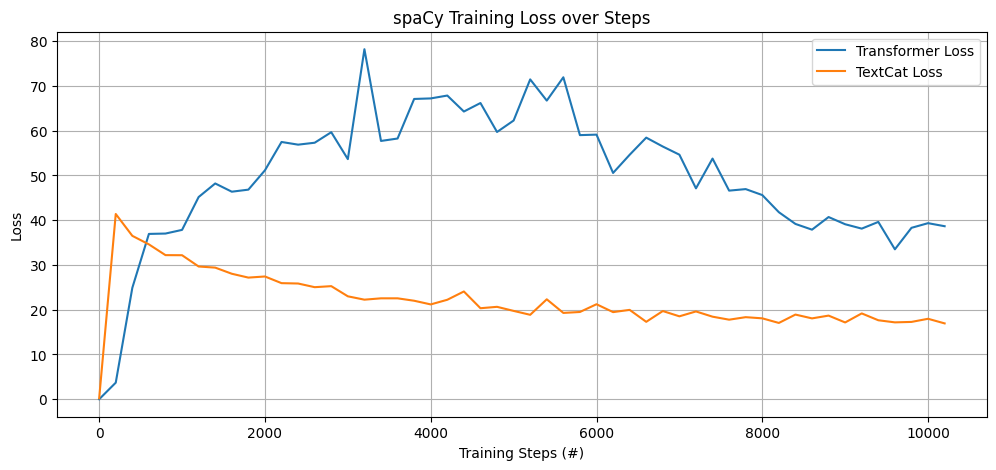

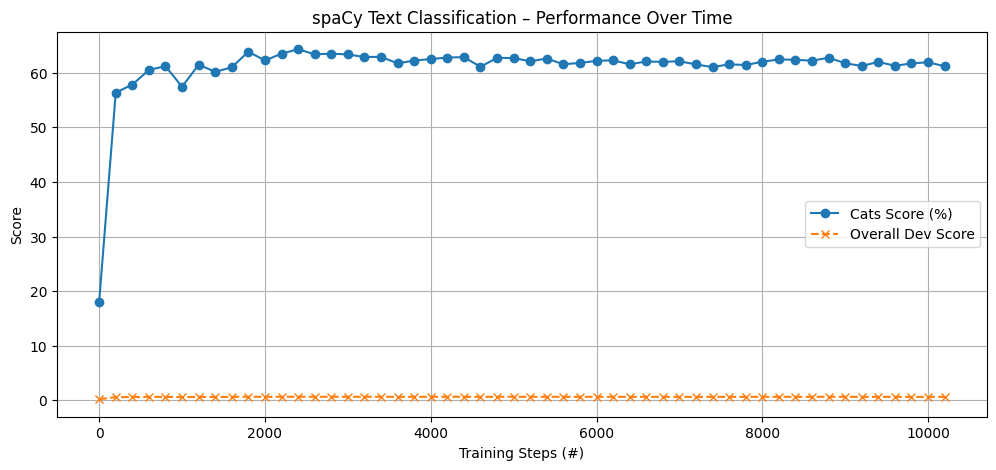

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# New log values (the ones YOU pasted)
log_text = """
E,#,LOSS_TRANS,LOSS_TEXTCAT,CATS_SCORE,SCORE
0,0,0.00,0.22,18.06,0.18
0,200,3.70,41.38,56.37,0.56
0,400,24.89,36.50,57.83,0.58
1,600,36.93,34.59,60.53,0.61
1,800,37.01,32.19,61.21,0.61
2,1000,37.83,32.17,57.43,0.57
2,1200,45.17,29.65,61.48,0.61
2,1400,48.20,29.40,60.18,0.60
3,1600,46.36,28.03,61.01,0.61
3,1800,46.82,27.17,63.87,0.64
4,2000,51.14,27.42,62.26,0.62
4,2200,57.47,25.93,63.50,0.63
4,2400,56.87,25.85,64.32,0.64
5,2600,57.30,25.03,63.38,0.63
5,2800,59.65,25.26,63.51,0.63
6,3000,53.64,22.99,63.36,0.63
6,3200,78.19,22.24,62.90,0.63
6,3400,57.70,22.54,62.92,0.63
7,3600,58.24,22.54,61.73,0.62
7,3800,67.08,22.00,62.24,0.62
8,4000,67.20,21.18,62.52,0.63
8,4200,67.84,22.22,62.79,0.63
8,4400,64.27,24.07,62.88,0.63
9,4600,66.17,20.33,61.10,0.61
9,4800,59.70,20.64,62.74,0.63
10,5000,62.26,19.73,62.70,0.63
10,5200,71.45,18.86,62.11,0.62
10,5400,66.71,22.32,62.61,0.63
11,5600,71.92,19.28,61.57,0.62
11,5800,59.00,19.49,61.81,0.62
12,6000,59.11,21.22,62.18,0.62
12,6200,50.55,19.46,62.30,0.62
13,6400,54.61,19.96,61.55,0.62
13,6600,58.44,17.29,62.08,0.62
13,6800,56.45,19.70,62.00,0.62
14,7000,54.63,18.52,62.12,0.62
14,7200,47.11,19.61,61.53,0.62
15,7400,53.76,18.44,61.04,0.61
15,7600,46.60,17.77,61.55,0.62
15,7800,46.94,18.33,61.43,0.61
16,8000,45.61,18.07,62.02,0.62
16,8200,41.78,17.04,62.45,0.62
17,8400,39.16,18.91,62.38,0.62
17,8600,37.88,18.06,62.22,0.62
17,8800,40.70,18.68,62.76,0.63
18,9000,39.09,17.15,61.76,0.62
18,9200,38.11,19.17,61.24,0.61
19,9400,39.61,17.64,62.00,0.62
19,9600,33.49,17.17,61.29,0.61
19,9800,38.29,17.27,61.71,0.62
20,10000,39.33,17.97,61.94,0.62
20,10200,38.65,16.94,61.19,0.61
"""

# Load into DataFrame
df = pd.read_csv(StringIO(log_text))

# Plot Losses
plt.figure(figsize=(12,5))
plt.plot(df["#"], df["LOSS_TRANS"], label="Transformer Loss")
plt.plot(df["#"], df["LOSS_TEXTCAT"], label="TextCat Loss")
plt.xlabel("Training Steps (#)")
plt.ylabel("Loss")
plt.title("spaCy Training Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot Scores
plt.figure(figsize=(12,5))
plt.plot(df["#"], df["CATS_SCORE"], marker="o", label="Cats Score (%)")
plt.plot(df["#"], df["SCORE"], marker="x", linestyle="--", label="Overall Dev Score")
plt.xlabel("Training Steps (#)")
plt.ylabel("Score")
plt.title("spaCy Text Classification – Performance Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the best model to your Drive (takes ~1.1 GB for roberta-base)
!cp -r /content/output_roberta_textcat/model-best "/content/drive/MyDrive/roberta_hate_speech_model"

print("Model saved to your Google Drive → MyDrive/roberta_hate_speech_model")

Mounted at /content/drive
Model saved to your Google Drive → MyDrive/roberta_hate_speech_model
